# Siamese Network v2.0
## 18 Feb 2025

Iteration 1.

(Agenda of this notebook)
- I Wont be tackling data augumentation in this notebook




Pretrained Models:
1. ResNet18
2. ResNet50


Todo:
1. Drop in Replacement of Pretrained Models, To Quickly Asses Their Performance
2. Training Visualization
3. More Robust Method of Model Evalutation
4. Transparency Methods for Models
5. Make it easier to make architectural changes to network. (Make things modularized)
6. Make the notebook self sufficient
    - in terms of explanation



Experiments
- [ ] Test Pretrained Models and their variance on given dataset.



In [ ]:
import torch
from torch import nn
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
import helpers as helper
import random
from IPython.display import display
from torchvision.models import ResNet50_Weights, ResNet18_Weights
from PIL import Image
from matplotlib import pyplot as plt
import cv2

GITHUB_REPO = "pytorch/vision:v0.10.0"
MODEL = "resnet50"

resnet50 = torch.hub.load(GITHUB_REPO, MODEL, weights=ResNet50_Weights.DEFAULT)
resnet18 = torch.hub.load(GITHUB_REPO, "resnet18", weights=ResNet18_Weights.DEFAULT)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu" )
print(f"{DEVICE=}")

Using cache found in /home/someone/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/someone/.cache/torch/hub/pytorch_vision_v0.10.0


DEVICE=device(type='cuda')


In [3]:



pretrained_models_available = [ f"{i + 1} | {model_name} |" for i, model_name in enumerate(torch.hub.list(GITHUB_REPO)) ]
    

from IPython.display import Markdown, display_markdown



table_models = Markdown(f'''
| Serial Number | Model Name |
|---------------|------------|
{"\n".join(pretrained_models_available)}}}
''')

display_markdown(table_models)


Using cache found in /home/someone/.cache/torch/hub/pytorch_vision_v0.10.0



| Serial Number | Model Name |
|---------------|------------|
1 | alexnet |
2 | deeplabv3_mobilenet_v3_large |
3 | deeplabv3_resnet101 |
4 | deeplabv3_resnet50 |
5 | densenet121 |
6 | densenet161 |
7 | densenet169 |
8 | densenet201 |
9 | fcn_resnet101 |
10 | fcn_resnet50 |
11 | googlenet |
12 | inception_v3 |
13 | lraspp_mobilenet_v3_large |
14 | mnasnet0_5 |
15 | mnasnet0_75 |
16 | mnasnet1_0 |
17 | mnasnet1_3 |
18 | mobilenet_v2 |
19 | mobilenet_v3_large |
20 | mobilenet_v3_small |
21 | resnet101 |
22 | resnet152 |
23 | resnet18 |
24 | resnet34 |
25 | resnet50 |
26 | resnext101_32x8d |
27 | resnext50_32x4d |
28 | shufflenet_v2_x0_5 |
29 | shufflenet_v2_x1_0 |
30 | squeezenet1_0 |
31 | squeezenet1_1 |
32 | vgg11 |
33 | vgg11_bn |
34 | vgg13 |
35 | vgg13_bn |
36 | vgg16 |
37 | vgg16_bn |
38 | vgg19 |
39 | vgg19_bn |
40 | wide_resnet101_2 |
41 | wide_resnet50_2 |}


- Why choose a pretrained model, and why this one ?
- Its architecture, and upto which layer am i using. (Finetuning, or just as an encoder).


In [4]:
# HYPER PARAMETERS


MARGIN = 0.7
LR = 3E-4
NUM_EPOCHS = 1000

BATCH_SIZE = 64




- What is Siamese Network, why have this why not anything else ?

In [ ]:

iac_image_paths = []
for current, subdir, files in os.walk("../IAC Transformed"):
    for name in files:
        if name.endswith("png"): iac_image_paths += [ f"{current}/{name}" ]
        


- Basics About Dataset

In [ ]:



pos_paths = []
neg_paths = iac_image_paths 


for current, subdir, files in os.walk("../ThermoDataBase"):
    for name in [ file for file in files if file.endswith("csv") ]:
        curr = pos_paths if "DM" in name else neg_paths
        curr += [ f"{current}/{name}" ] 

heatmap_paths_labels = np.c_[[ *pos_paths, *neg_paths], [ *([1]*len(pos_paths)), *([0]*len(neg_paths)) ]] 

Counter({np.str_('1'): 244, np.str_('0'): 166})


<BarContainer object of 2 artists>

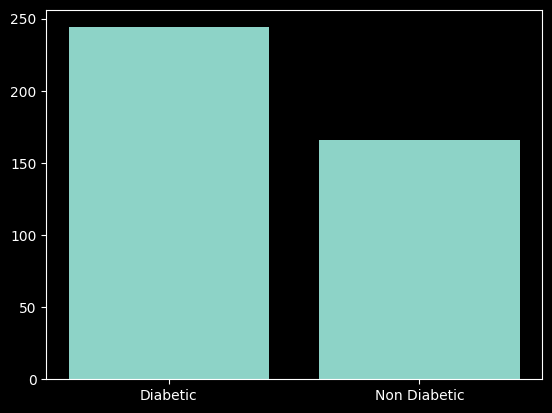

In [7]:
from collections import Counter

np.random.shuffle(heatmap_paths_labels)
dataset_count = Counter(heatmap_paths_labels[:, 1])
print(dataset_count)
plt.bar(
    x=["Diabetic", "Non Diabetic"],
    height=[ dataset_count["1"], dataset_count["0"] ])

<BarContainer object of 2 artists>

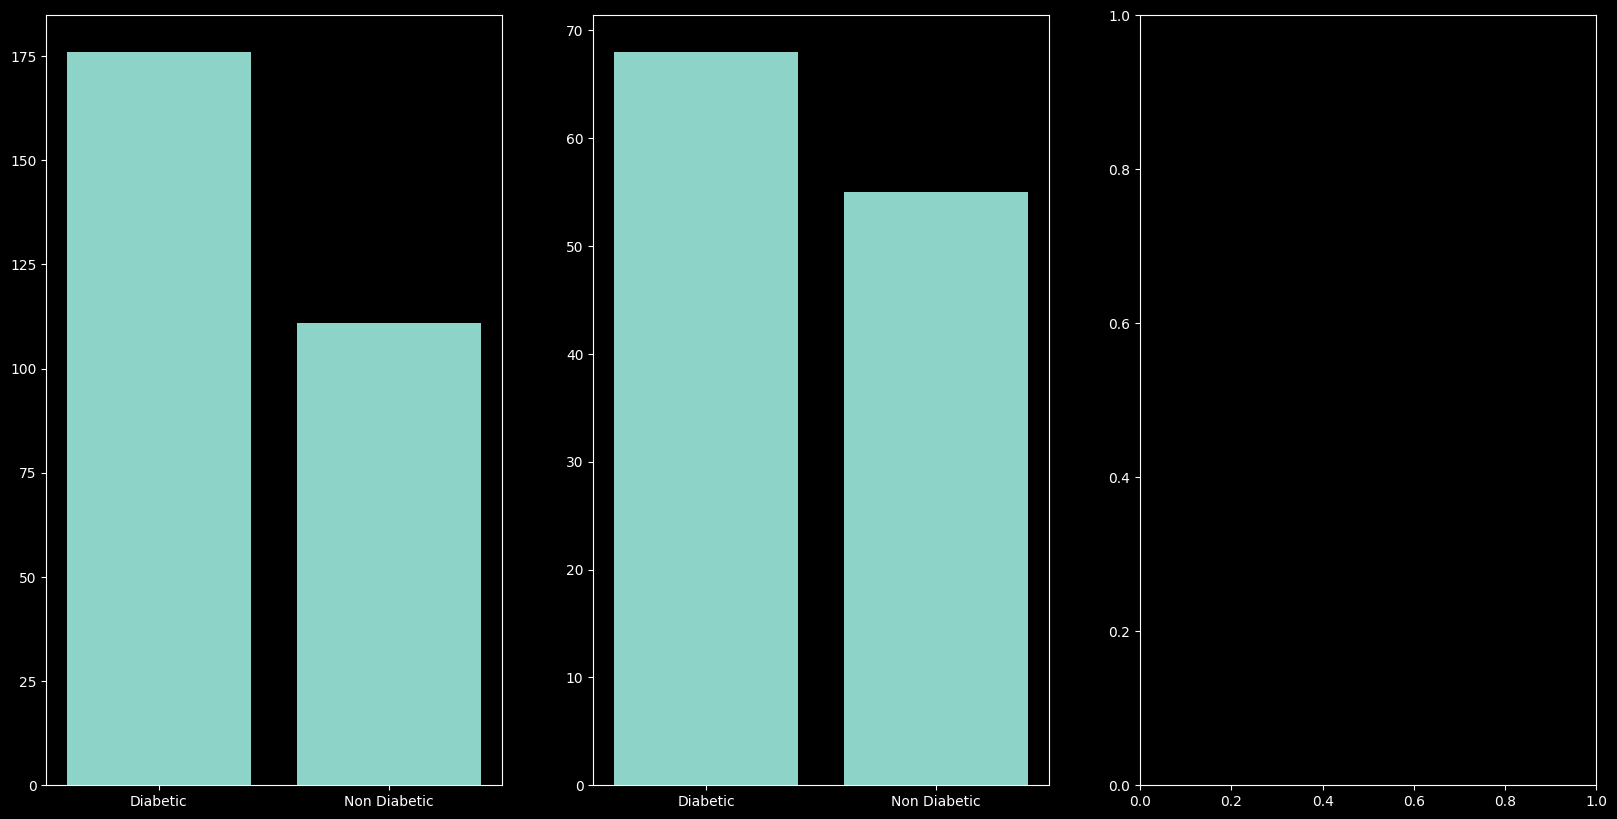

In [8]:
TRAINING_DATA_RATIO   = 0.7
VALIDATION_DATA_RATIO = 0
TESTING_DATA_RATIO    = 0.3

assert TRAINING_DATA_RATIO + TESTING_DATA_RATIO + VALIDATION_DATA_RATIO == 1

TOTAL_COUNT = len(heatmap_paths_labels)

train_paths_labels = heatmap_paths_labels[:int(TOTAL_COUNT * TRAINING_DATA_RATIO)]
validation_paths_labels  = heatmap_paths_labels[len(train_paths_labels):len(train_paths_labels) + int(TOTAL_COUNT * VALIDATION_DATA_RATIO)]
test_paths_labels = heatmap_paths_labels[len(validation_paths_labels) + len(train_paths_labels):]

np.random.shuffle(train_paths_labels)
np.random.shuffle(test_paths_labels)
np.random.shuffle(validation_paths_labels)
# Graph Showing Proportions for each Case

fig, ax = plt.subplots(1, 3, figsize=(20, 10))
c_train = Counter(train_paths_labels[:, 1])
c_test = Counter(test_paths_labels[:, 1])
c_valid = Counter(validation_paths_labels[:, 1])

ax[0].bar(
    x = [ "Diabetic", "Non Diabetic" ],
    height = [ c_train['1'], c_train['0'] ],
)



ax[1].bar(
    x = [ "Diabetic", "Non Diabetic" ],
    height = [ c_test['1'], c_test['0'] ]
)

ax[0].bar(
    x = [ "Diabetic", "Non Diabetic" ],
    height = [ c_valid['1'], c_valid['0'] ]
)

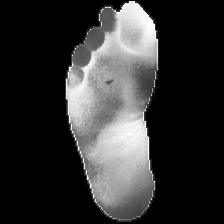

In [ ]:

IMAGE_SIZE = (96, 222) # W, H 
INPUT_SIZE = (224, 224)
normalize = lambda x : (x - x.min()) / (x.max() - x.min())

clahe = cv2.createCLAHE(clipLimit=30, tileGridSize=(2, 2))
    


def read_csv(path): 
    data = np.uint8(normalize(np.float32(pd.read_csv(path))) * 255)
    im = Image.fromarray(data).resize(IMAGE_SIZE)
    data = np.uint8(im)
    return data

def read_iac_image(path):
    im = Image.open(f"{path}").resize(IMAGE_SIZE)
    data = np.uint8(normalize(np.float32(im)) * 255)
    im.close()
    return data

def read_data(path):
    data = None
    if path.endswith("csv"):
        data =  read_csv(path)
    else:
        data = read_iac_image(path)
    mask = np.uint8(np.where(data > 0, 1, 0))
    data = clahe.apply(data) * mask
    tensor = transforms.ToTensor()(data)

    canvas = torch.zeros(INPUT_SIZE)
    
    for x_index in range((INPUT_SIZE[0] - IMAGE_SIZE[0]) // 2, (INPUT_SIZE[0] - IMAGE_SIZE[0]) // 2 + IMAGE_SIZE[0]):
        for y_index in range((INPUT_SIZE[1] - IMAGE_SIZE[1]) // 2, (INPUT_SIZE[1] - IMAGE_SIZE[1]) // 2 + IMAGE_SIZE[1]):
            xx_index = x_index - (INPUT_SIZE[0] - IMAGE_SIZE[0]) // 2
            yy_index = y_index - (INPUT_SIZE[1] - IMAGE_SIZE[1]) // 2
            canvas[y_index][x_index] = tensor[0][yy_index][xx_index]

    return torch.stack([canvas, canvas, canvas])
    
transforms.ToPILImage()(read_data(random.choice(heatmap_paths_labels[:, 0])))



(np.float64(0.0), np.float64(1.0), np.float64(0.0), np.float64(1.0))

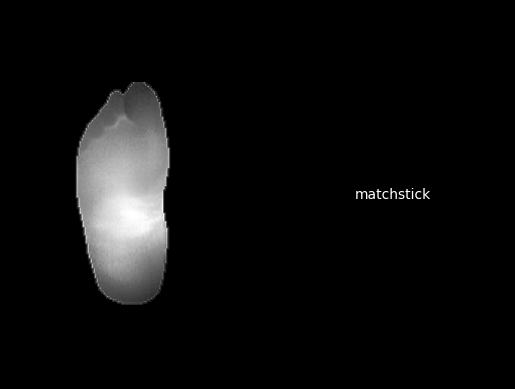

In [10]:
# What ResNet Thinks of Dataset

file = open("imagenet_classes.txt", "r")
imagenet_labels = [ label.strip() for index, label in enumerate(file.readlines()) ]

inp = read_data(random.choice(heatmap_paths_labels[:, 0])).unsqueeze(0)

logits = resnet50(inp)
probs = torch.functional.F.softmax(logits, dim=1)



fig, ax = plt.subplots(1, 2)
ax[0].imshow(transforms.ToPILImage()(inp[0]))
ax[1].text(0.5, 0.5, f"{imagenet_labels[torch.argmax(probs).item()]}", va="center", ha="center")
ax[0].axis("off")
ax[1].axis("off")

In [11]:
import random

class SiameseDataset(torch.utils.data.Dataset):
    def __init__(self, paths, precompute=True):
        self.paths = paths
        self.pos_paths = [ (i, path) for i, path in enumerate(paths) if "DM Group" in path]
        self.neg_paths = [ (i, path) for i, path in enumerate(paths) if "Control Group" in path]

        self.test_pos = lambda path : "DM Group" in path
        self.precompute = precompute
        if self.precompute:
            self.train_data = torch.stack([ read_data(path) for path in self.paths ])
    

    def __getitem__(self, index):
        anchor = self.paths[index]
        pos,neg = None, None
        if self.test_pos(anchor):
            i_pos = random.choice(self.pos_paths)[0]
            i_neg = random.choice(self.neg_paths)[0]
        else:
            i_pos = random.choice(self.neg_paths)[0]
            i_neg = random.choice(self.pos_paths)[0]
        if not self.precompute :
            anchor = read_data(anchor)
            pos = read_data(self.paths[i_pos])
            neg = read_data(self.paths[i_neg])
        else:
            anchor = self.train_data[index]
            pos = self.train_data[i_pos]
            neg = self.train_data[i_neg]

        return anchor, pos, neg

    def __len__(self): return len(self.paths)

In [12]:


class SiameseNetwork_Encoder_Resnet18(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = nn.Sequential(*list(resnet18.children())[:-1])
        self.layer = nn.Sequential(
            nn.Flatten(1),
            nn.ReLU(),
            nn.Linear(512, 50)
        )
        for param in self.resnet.parameters():
            param.requires_grad = False
        for param in self.resnet[-2].parameters():
            param.requires_grad = True
        self.epoch = 0

    def forward(self, x):
        return self.layer(self.resnet(x))

    def train(self, optimizer, criterion, lr_scheduler, dataloader, num_epochs, epoch_callback = None):
        while self.epoch != num_epochs:
            loss_v = 0
            n = 0
            for sample in dataloader:
                optimizer.zero_grad()
                anchor, pos, neg = sample
                fa = self(anchor.to(DEVICE))
                fp = self(pos.to(DEVICE))
                fn = self(neg.to(DEVICE))
                loss = criterion(fa, fp, fn)
                loss_v += loss.item()
                n += 1
                loss.backward()
                optimizer.step()
            lr_scheduler.step()
            loss_v /= n
            if epoch_callback : epoch_callback(self, loss_v)
            self.epoch += 1

    def save(self):
        if helper.helper_save_model(self, self.epoch) :
            print(f"[INFO, Model]: Model Saved Sucessfully, {self.epoch=}")
        else:
            print("[ERROR, Model]: Unable to Save Model")
        
    def load(self, epoch = -1):
        try:
            max_name = None
            max_epoch = -1
            for model_name in [ x for x in os.listdir("model") if x.endswith("sdict") ]:
                cur_epoch = int(model_name.split("_")[-1].split(".")[0].strip())
                if cur_epoch > max_epoch:
                    max_name = model_name
                    max_epoch = cur_epoch
                if cur_epoch == epoch:
                    max_name = model_name
                    max_epoch = epoch
                    break
            state_dict = torch.load(f"model/{max_name}", weights_only=True)
            self.load_state_dict(state_dict)
            self.epoch = max_epoch
            print(f"[INFO, Model]: Sucessfully Loaded with epoch={self.epoch}")
        except Exception as e:
            print(f"[ERROR, Model]: Unable to Load Model {max_name}|", e)
    
    


In [32]:
class SiameseNetwork_Encoder_Resnet50(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = nn.Sequential(*list(resnet50.children())[:-1])
        self.layer = nn.Sequential(
            nn.Flatten(1),
            nn.ReLU(),
            nn.Linear(2048, 50)
        )
        for param in self.resnet.parameters():
            param.requires_grad = True
        self.epoch = 0
        self.loss_v = 0

    def forward(self, x):
        return self.layer(self.resnet(x))

    def train(self, optimizer, criterion, lr_scheduler, dataloader, num_epochs, epoch_callback = None):
        while self.epoch != num_epochs:
            loss_v = 0
            n = 0
            for sample in dataloader:
                optimizer.zero_grad()
                anchor, pos, neg = sample
                fa = self(anchor.to(DEVICE))
                fp = self(pos.to(DEVICE))
                fn = self(neg.to(DEVICE))
                loss = criterion(fa, fp, fn)
                loss_v += loss.item()
                n += 1
                loss.backward()
                optimizer.step()
            lr_scheduler.step()
            loss_v /= n
            if epoch_callback : epoch_callback(self, loss_v)
            self.epoch += 1
            self.loss_v = loss_v

    def save(self):
        if helper.helper_save_model(self, self.epoch) :
            print(f"[INFO, Model]: Model Saved Sucessfully, {self.epoch=}")
        else:
            print("[ERROR, Model]: Unable to Save Model")
        
    def load(self, epoch = -1):
        try:
            max_name = None
            max_epoch = -1
            for model_name in [ x for x in os.listdir("model") if x.endswith("sdict") ]:
                cur_epoch = int(model_name.split("_")[-1].split(".")[0].strip())
                if cur_epoch > max_epoch:
                    max_name = model_name
                    max_epoch = cur_epoch
                if cur_epoch == epoch:
                    max_name = model_name
                    max_epoch = epoch
                    break
            state_dict = torch.load(f"model/{max_name}", weights_only=True)
            self.load_state_dict(state_dict)
            self.epoch = max_epoch
            print(f"[INFO, Model]: Sucessfully Loaded with epoch={self.epoch}")
        except Exception as e:
            print(f"[ERROR, Model]: Unable to Load Model {max_name}|", e)
    

    
model = SiameseNetwork_Encoder_Resnet50().to(DEVICE)
model.load()

[ERROR, Model]: Unable to Load Model siamese_2000.sdict| Error(s) in loading state_dict for SiameseNetwork_Encoder_Resnet50:
	Missing key(s) in state_dict: "resnet.4.0.conv3.weight", "resnet.4.0.bn3.weight", "resnet.4.0.bn3.bias", "resnet.4.0.bn3.running_mean", "resnet.4.0.bn3.running_var", "resnet.4.0.downsample.0.weight", "resnet.4.0.downsample.1.weight", "resnet.4.0.downsample.1.bias", "resnet.4.0.downsample.1.running_mean", "resnet.4.0.downsample.1.running_var", "resnet.4.1.conv3.weight", "resnet.4.1.bn3.weight", "resnet.4.1.bn3.bias", "resnet.4.1.bn3.running_mean", "resnet.4.1.bn3.running_var", "resnet.4.2.conv1.weight", "resnet.4.2.bn1.weight", "resnet.4.2.bn1.bias", "resnet.4.2.bn1.running_mean", "resnet.4.2.bn1.running_var", "resnet.4.2.conv2.weight", "resnet.4.2.bn2.weight", "resnet.4.2.bn2.bias", "resnet.4.2.bn2.running_mean", "resnet.4.2.bn2.running_var", "resnet.4.2.conv3.weight", "resnet.4.2.bn3.weight", "resnet.4.2.bn3.bias", "resnet.4.2.bn3.running_mean", "resnet.4.2.bn3

In [14]:


criterion = nn.TripletMarginLoss(MARGIN)
optimizer = torch.optim.Adam(model.parameters(), lr=3E-10)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)



In [15]:
dataset = SiameseDataset(train_paths_labels[:, 0])


# Typical Time: 3m 34s

In [16]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

In [23]:
import matplotlib

from sklearn.manifold import TSNE
matplotlib.use("tkagg")

training_on_going = True

vd = helper.VisualEmbeddingsDashboard("Siamese Network (Resnetv2)")

y_train = train_paths_labels[:, 1]

def visual_epoch_callback(signal):
    while training_on_going:
        signal.wait()
        model_cpu = model.layer
        # tsne = TSNE(n_components=2)
        embedding_train = model_cpu(dataset.train_data).detach().numpy()
        print(embedding_train.shape)
        # embedding_2d = tsne.fit_transform(embedding_train)
        # vd.embedding_ax.clear()
        # vd.plot_loss(model.epoch, model.loss_v)
        # vd.plot_embeddings(embedding_2d, lambda x: (1, 0, 0) if y_train[x] == 1 else (0, 1, 0) )
        # vd.update()
        # vd.save_image()
        signal.clear()
    print("Thread Closed!!")
import threading

signal_epoch_done = threading.Event()
signal_epoch_done.clear()


t = threading.Thread(target=visual_epoch_callback, args=(signal_epoch_done, ))

t.start()

Exception in thread Thread-12 (visual_epoch_callback):
Traceback (most recent call last):
  File "/usr/lib/python3.12/threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "/home/someone/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.12/threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_8781/4119486684.py", line 17, in visual_epoch_callback
  File "/home/someone/.local/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/someone/.local/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/someone/.local/lib/python3.12/site-packages/torch/nn/modules/container.py", line 

In [25]:
training_on_going = False
signal_epoch_done.set()
t.join()

In [ ]:
# Visualizing Embedding Design


def epoch_callback(model, loss_v):
    
    print(f"{model.epoch=}: Done, {loss_v=}")
    # signal_epoch_done.set()
    

# model.epoch = 0
try:
    model.train(optimizer,criterion,lr_sched,dataloader,NUM_EPOCHS,epoch_callback)
except Exception as e:
    print(e)
finally:
    training_on_going = False

In [23]:
def path_to_embedding(path, model):
    data = read_data(path).unsqueeze(0)
    if DEVICE == torch.device("cpu"): return model(data).detach().numpy()
    return model(data.to(DEVICE)).to("cpu").detach().numpy()

def paths_to_embedding(paths,model):
    data = torch.stack([ read_data(path) for path in paths ])
    if DEVICE == torch.device("cpu"): return model(data).detach().numpy()
    return model(data.to(DEVICE)).to("cpu").detach().numpy()

def paths_to_embedding_(paths,model):
    data = torch.stack([ read_data(path) for path in paths ]).to(DEVICE)
    return model(data).detach().numpy()

def paths_to_embedding_cpu(paths, model):
    return model.to("cpu")(torch.stack([ read_data(path) for path in paths ])).detach().numpy()



In [30]:
train_embeddings = paths_to_embedding_cpu(train_paths_labels[:, 0], model)
test_embeddings = paths_to_embedding_cpu(test_paths_labels[:, 0], model)


#Time (ResNet18): 4m 43sec
#Time (ResNet50): 7m 7sec

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svc = SVC(kernel="rbf")

svc.fit(train_embeddings, train_paths_labels[:, 1])
y_pred = svc.predict(train_embeddings)

train_ac = accuracy_score(y_pred, train_paths_labels[:, 1]) * 100

y_test_pred = svc.predict(test_embeddings)
test_ac = accuracy_score(test_paths_labels[:, 1], y_test_pred) * 100

print(f"{train_ac=}, {test_ac=}")

train_ac=93.03135888501743, test_ac=80.48780487804879
